In [1]:
import pandas as pd
import numpy as np

dtypes = {
    'molregno':'int64',
    'comp_id':'object',
    'target':'object',
    'relation':'object',
    'bioactivity':'float64',
    'units':'object',
    'type':'object',
    'potential_duplicates':'int64',
    'smiles':'object',
    'sequence':'object'
}

df = pd.read_csv('./data_final_con_seq.csv',sep='\t',dtype=dtypes,names=list(dtypes),na_values='\\N')

df

,molregno,comp_id,target,relation,bioactivity,units,type,potential_duplicates,smiles,sequence
0,1173470,CHEMBL1823380,CHEMBL4808,=,4200.0,nM,IC50,0,CCc1cc(C2=CCC[C@@H]3CC[C@H]2N3)on1,MEPWPLLLLFSLCSAGLVLGSEHETRLVAKLFKDYSSVVRPVEDHR...
1,1173471,CHEMBL1823381,CHEMBL4808,=,5500.0,nM,IC50,0,CC(C)c1cc(C2=CCC[C@@H]3CC[C@H]2N3)on1,MEPWPLLLLFSLCSAGLVLGSEHETRLVAKLFKDYSSVVRPVEDHR...
2,1173472,CHEMBL1823382,CHEMBL4808,=,7800.0,nM,IC50,0,C1=C(c2cc(-c3ccccc3)no2)[C@H]2CC[C@@H](CC1)N2,MEPWPLLLLFSLCSAGLVLGSEHETRLVAKLFKDYSSVVRPVEDHR...
3,115,CHEMBL3,CHEMBL4808,=,21000.0,nM,IC50,0,CN1CCC[C@H]1c1cccnc1,MEPWPLLLLFSLCSAGLVLGSEHETRLVAKLFKDYSSVVRPVEDHR...
4,675,CHEMBL6623,CHEMBL4808,=,160.0,nM,IC50,0,Clc1ccc(C2CC3CCC2N3)cn1,MEPWPLLLLFSLCSAGLVLGSEHETRLVAKLFKDYSSVVRPVEDHR...
...,...,...,...,...,...,...,...,...,...,...
1356321,2505712,CHEMBL4758375,CHEMBL4888453,=,1.0,nM,EC50,0,C[C@H](NC(=O)Cn1nc2cc(OC3COC3)ccn2c1=O)c1ccc(O...,MEHTHAHLAANSSACGLGFVPVVYYSFLLCLGLPANILTVIILSQL...
1356322,2512176,CHEMBL4764839,CHEMBL4888453,=,1.0,nM,EC50,0,C[C@H](NC(=O)Cn1nc2cc(N3CCC(O)CC3)ccn2c1=O)c1c...,MEHTHAHLAANSSACGLGFVPVVYYSFLLCLGLPANILTVIILSQL...
1356323,2503729,CHEMBL4756392,CHEMBL4888453,=,10.0,nM,EC50,0,C[C@H](NC(=O)Cn1nc2c(N3CCC34CNC4)cccn2c1=O)c1c...,MEHTHAHLAANSSACGLGFVPVVYYSFLLCLGLPANILTVIILSQL...
1356324,2494990,CHEMBL4747632,CHEMBL4888453,=,10.0,nM,EC50,0,C[C@H](NC(=O)Cn1nc2c(N3CCC34CN(C)C4)cccn2c1=O)...,MEHTHAHLAANSSACGLGFVPVVYYSFLLCLGLPANILTVIILSQL...


Se deben descartar todas las entradas que no tengan bioactividad

In [2]:
print(f'Entries previous null biactivity deletion {len(df.index)}')
df = df[~df.bioactivity.isnull()]
df.head()
print(f'Entries after null biactivity deletion {len(df.index)}')


Entries previous null biactivity deletion 1356326
Entries after null biactivity deletion 1356294


Aquellos ensayos repetidos, y de la misma tecnica se unifican utilizando la mediana, como se indica en el paper

In [3]:
print(f'Entries previous bioactivity unification {len(df.index)}')
df = df.groupby(['target','comp_id','relation','type','smiles','sequence','molregno','units'],as_index=False)['bioactivity'].median()
print(f'Entries previous bioactivity unification {len(df.index)}')

Entries previous bioactivity unification 1356294
Entries previous bioactivity unification 1129625


Se define el threshold de bioactividad como en el paper, y se eliminan los ensayos que no estan dentro del theshold
    activo <= 10 mM
    inactivo >= 20 mM

In [4]:
print(f'Entries previous bioactivity binarization {len(df.index)}')

def step_func_bioactivity(x):
    if x <= 10000: 
        return 1 
    elif x >= 20000:
        return 0
    else:
        return pd.NA

df['binary_bioactivity'] = df['bioactivity'].apply(step_func_bioactivity)
df = df[~df.binary_bioactivity.isnull()]
print(f'Entries previous bioactivity binarization {len(df.index)}')

Entries previous bioactivity binarization 1129625
Entries previous bioactivity binarization 1061896


Se encuentra que aun hay ensayos duplicados pues son de distinto tipo, por lo tanto se procede a descartar aquellos ensayos que resulten en una bioactividad binaria distinta.
Aquellos que resulten en una bioactividad binaria igual se conservará aleatoriamente el primero

In [5]:
df[df.duplicated(subset=['comp_id','target','relation'], keep=False)]

,target,comp_id,relation,type,smiles,sequence,molregno,units,bioactivity,binary_bioactivity
277,CHEMBL1075045,CHEMBL577547,=,IC50,CN1CC(C(=O)O)=Nc2c1nc(N)[nH]c2=O,MCSLKWDYDLRCGEYTLNLNEKTLIMGILNVTPDSFSDGGSYNEVD...,577219,nM,32400.0,0
278,CHEMBL1075045,CHEMBL577547,=,Kd,CN1CC(C(=O)O)=Nc2c1nc(N)[nH]c2=O,MCSLKWDYDLRCGEYTLNLNEKTLIMGILNVTPDSFSDGGSYNEVD...,577219,nM,5260.0,1
556,CHEMBL1075060,CHEMBL4754674,=,IC50,Oc1ccc(CNc2ccc(O)c(O)c2)cc1O,MSSKPQSIGVIGAPFSKGQPRGGVEEGPTVLRKAGLLEKLKELECD...,2502011,nM,76000.0,0
557,CHEMBL1075060,CHEMBL4754674,=,Ki,Oc1ccc(CNc2ccc(O)c(O)c2)cc1O,MSSKPQSIGVIGAPFSKGQPRGGVEEGPTVLRKAGLLEKLKELECD...,2502011,nM,82000.0,0
682,CHEMBL1075089,CHEMBL223867,=,IC50,COc1cc(C=O)ccc1OCc1ccccc1COc1ccc(/C=C2/SC(=S)N...,MQHLVLIGFMGSGKSSLAQELGLALKLEVLDTDMIISERVGLSVRE...,376426,nM,5500.0,1
...,...,...,...,...,...,...,...,...,...,...
1129475,CHEMBL6194,CHEMBL1650465,=,Ki,O=C(CCCl)Nc1nnc(CCCl)s1,MTAPTVPVALVTGAAKRLGRSIAEGLHAEGYAVCLHYHRSAAEANA...,1062189,nM,7000.0,1
1129486,CHEMBL6194,CHEMBL318275,=,IC50,Nc1nc2ccc([N+](=O)[O-])cc2s1,MTAPTVPVALVTGAAKRLGRSIAEGLHAEGYAVCLHYHRSAAEANA...,157617,nM,40000.0,0
1129487,CHEMBL6194,CHEMBL318275,=,Ki,Nc1nc2ccc([N+](=O)[O-])cc2s1,MTAPTVPVALVTGAAKRLGRSIAEGLHAEGYAVCLHYHRSAAEANA...,157617,nM,3000.0,1
1129538,CHEMBL6194,CHEMBL744,=,IC50,Nc1nc2ccc(OC(F)(F)F)cc2s1,MTAPTVPVALVTGAAKRLGRSIAEGLHAEGYAVCLHYHRSAAEANA...,38898,nM,72050.0,0


In [6]:
print(f'Entries previous assay type conflict cleaning {len(df.index)}')

# Se conserva solo los que tengan una bioactividad binaria igual para todos los ensayos
df = df.groupby(['comp_id','target','relation'],as_index=False).filter(lambda g: (g['binary_bioactivity'].nunique() == 1))

# Se descartan los duplicados y se conserva aleatoriamente el primer resultado
df = df.drop_duplicates(subset=['comp_id','target','relation'],keep='first')

print(f'Entries after assay type conflict cleaning {len(df.index)}')


Entries previous assay type conflict cleaning 1061896
Entries after assay type conflict cleaning 1025198


In [7]:
df[df.duplicated(subset=['comp_id','target'],keep=False)]

,target,comp_id,relation,type,smiles,sequence,molregno,units,bioactivity,binary_bioactivity
850033,CHEMBL3979,CHEMBL121,=,EC50,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,MEQPQEEAPEVREEEEKEEVAEAEGAPELNGGPQHALPSSSYTDLS...,20027,nM,4434.0,1
850034,CHEMBL3979,CHEMBL121,>,IC50,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,MEQPQEEAPEVREEEEKEEVAEAEGAPELNGGPQHALPSSSYTDLS...,20027,nM,50000.0,0


In [8]:
cuenta_activos_inactivos = df.groupby(['target','binary_bioactivity']).count()

In [9]:
target_mas_de_100 = cuenta_activos_inactivos[cuenta_activos_inactivos.bioactivity >= 100].index

In [10]:
mejores_targets = list()
for i in target_mas_de_100:
    mejores_targets.append(i[0])

In [11]:
cuenta_activos_inactivos

comp_id  relation  type  smiles  sequence  \
target        binary_bioactivity                                              
CHEMBL1075021 1                        35        35    35      35        35   
CHEMBL1075022 1                        35        35    35      35        35   
CHEMBL1075023 1                         3         3     3       3         3   
CHEMBL1075024 0                         2         2     2       2         2   
              1                        24        24    24      24        24   
...                                   ...       ...   ...     ...       ...   
CHEMBL6194    1                        28        28    28      28        28   
CHEMBL6195    0                         6         6     6       6         6   
              1                         1         1     1       1         1   
CHEMBL6197    1                        67        67    67      67        67   
CHEMBL6198    1                         9         9     9       9         9   

                                  molregno  units  bioactivity  
target        binary_bioactivity                                
CHEMBL1075021 1                         35     35           35  
CHEMBL1075022 1                         35     35           35  
CHEMBL1075023 1                          3      3            3  
CHEMBL1075024 0                          2      2            2  
              1                         24     24           24  
...                                    ...    ...          ...  
CHEMBL6194    1                         28     28           28  
CHEMBL6195    0                          6      6            6  
              1                          1      1            1  
CHEMBL6197    1                         67     67           67  
CHEMBL6198    1                          9      9            9  

[8683 rows x 8 columns]

In [12]:
 mejores_target_actinact = cuenta_activos_inactivos[cuenta_activos_inactivos.index.isin(mejores_targets, level='target')]

In [13]:
mejores_target_actinact

comp_id  relation  type  smiles  sequence  \
target        binary_bioactivity                                              
CHEMBL1075051 0                        25        25    25      25        25   
              1                       182       182   182     182       182   
CHEMBL1075094 0                        16        16    16      16        16   
              1                       214       214   214     214       214   
CHEMBL1075097 0                         5         5     5       5         5   
...                                   ...       ...   ...     ...       ...   
CHEMBL6175    1                       401       401   401     401       401   
CHEMBL6184    0                        11        11    11      11        11   
              1                       217       217   217     217       217   
CHEMBL6185    0                         2         2     2       2         2   
              1                       109       109   109     109       109   

                                  molregno  units  bioactivity  
target        binary_bioactivity                                
CHEMBL1075051 0                         25     25           25  
              1                        182    182          182  
CHEMBL1075094 0                         16     16           16  
              1                        214    214          214  
CHEMBL1075097 0                          5      5            5  
...                                    ...    ...          ...  
CHEMBL6175    1                        401    401          401  
CHEMBL6184    0                         11     11           11  
              1                        217    217          217  
CHEMBL6185    0                          2      2            2  
              1                        109    109          109  

[2153 rows x 8 columns]

In [14]:
target_activo_vs_inactivo = cuenta_activos_inactivos.pivot_table(columns='binary_bioactivity',index='target',values='bioactivity')

In [15]:
target_activo_vs_inactivo_sinNA = target_activo_vs_inactivo.dropna(how='any')

In [19]:
target_activo_vs_inactivo_sinNA[1]

target
CHEMBL1075024    24.0
CHEMBL1075025    27.0
CHEMBL1075040     7.0
CHEMBL1075041     1.0
CHEMBL1075042     1.0
                 ... 
CHEMBL6186       19.0
CHEMBL6187        4.0
CHEMBL6188        1.0
CHEMBL6194       28.0
CHEMBL6195        1.0
Name: 1, Length: 3064, dtype: float64

<AxesSubplot:xlabel='1', ylabel='0'>

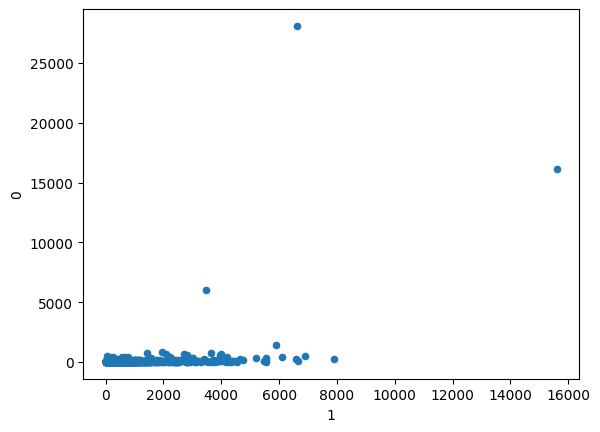

In [20]:

target_activo_vs_inactivo_sinNA.plot(x=1, y=0, kind='scatter')

In [39]:

target_activo_vs_inactivo_sinNA = target_activo_vs_inactivo_sinNA.sort_values(by=0,ascending=False)
target_activo_vs_inactivo_sinNA['ratio'] = target_activo_vs_inactivo_sinNA[1] / target_activo_vs_inactivo_sinNA[0]
target_activo_vs_inactivo_sinNA.head(20)

binary_bioactivity,0,1,ratio
target,,,
CHEMBL1293254,28098.0,6603.0,0.234999
CHEMBL1293224,16152.0,15598.0,0.965701
CHEMBL1075138,6045.0,3457.0,0.571878
CHEMBL240,1383.0,5890.0,4.258858
CHEMBL3471,861.0,1955.0,2.270616
CHEMBL4078,759.0,3659.0,4.820817
CHEMBL1951,706.0,1431.0,2.026912
CHEMBL335,660.0,2074.0,3.142424
CHEMBL5763,659.0,2697.0,4.092564


In [40]:
target_activo_vs_inactivo_sinNA[(target_activo_vs_inactivo_sinNA[1] > 100) & (target_activo_vs_inactivo_sinNA.ratio > 0.9) & (target_activo_vs_inactivo_sinNA.ratio < 1.4)]

binary_bioactivity,0,1,ratio
target,,,
CHEMBL1293224,16152.0,15598.0,0.965701
CHEMBL4803,233.0,292.0,1.253219
CHEMBL5445,148.0,180.0,1.216216
CHEMBL4161,145.0,146.0,1.006897
CHEMBL2169736,125.0,174.0,1.392000
CHEMBL1293311,122.0,154.0,1.262295
CHEMBL3238,109.0,115.0,1.055046
CHEMBL1806,109.0,131.0,1.201835
CHEMBL5847,97.0,115.0,1.185567


In [43]:
training_df = df[['target','comp_id','binary_bioactivity']].pivot(index='comp_id',columns='target',values='binary_bioactivity')

ValueError: Unstacked DataFrame is too big, causing int32 overflow